<img src = "../../Data/bgsedsc_0.jpg">

# Project: (K-) Nearest Neighbors and Support Vector Machines (SVM)

## Programming project: probability of death

In this project, you have to predict the probability of death of a patient that is entering an ICU (Intensive Care Unit).

The dataset comes from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Column HOSPITAL_EXPIRE_FLAG is the indicator of death (=1) as a result of the current hospital stay; this is the outcome to predict in our modelling exercise.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*. 

Note that the main cause/disease of patient contidition is embedded as a code at *ICD9_diagnosis* column. The meaning of this code can be found at *MIMIC_metadata_diagnose.csv*. **But** this is only the main one; a patient can have co-occurrent diseases (comorbidities). These secondary codes can be found at *extra_data/MIMIC_diagnoses.csv*.

Don't use features that you don't know the first day a patient enters the ICU, such as LOS.

As performance metric, you can use *AUC* for the binary classification case, but feel free to report as well any other metric if you can justify that is particularly suitable for this case.

Main tasks are:
+ Using *mimic_train.csv* file build a predictive model for *HOSPITAL_EXPIRE_FLAG* .
+ For this analysis there is an extra test dataset, *mimic_test.csv*. Apply your final model to this extra dataset and submit to Kaggle competition to obtain accuracy of prediction (follow the requested format).

Try to optimize hyperparameters of your SVM model.

You can follow those **steps** in your first implementation:
1. *Explore* and understand the dataset. 
2. Manage missing data.
2. Manage categorial features. E.g. create *dummy variables* for relevant categorical features, or build an ad hoc distance function.
3. Build a prediction model. Try to improve it using methods to tackle class imbalance.
5. Assess expected accuracy  of previous models using *cross-validation*. 
6. Test the performance on the test file by submitting to Kaggle, following same preparation steps (missing data, dummies, etc). Remember that you should be able to yield a prediction for all the rows of the test dataset.

For the in-class version, feel free to reduce the training dataset if you experience computational constraints.

## Main criteria for IN-CLASS grading
The weighting of these components will vary between the in-class and extended projects:
+ Code runs - 15%
+ Data preparation - 20%
+ SVMs method(s) have been used - 25%
+ Probability of death for each test patient is computed - 15%
+ Accuracy itself - 15%
+ Hyperparameter optimization - 10%
+ Class imbalance management - 0%
+ Neat and understandable code, with some titles and comments - 0%
+ Improved methods from what we discussed in class (properly explained/justified) - 0%


In [60]:
# Load libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from numpy import random 

import datetime as dt
from datetime import timedelta

from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures as plf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn import metrics
from sklearn.svm import SVC

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer

import category_encoders as ce
from category_encoders.woe import WOEEncoder

from imblearn.over_sampling import RandomOverSampler 
from utils.helper_functions import *

from sklearn.svm import SVR 

from sklearn.calibration import CalibratedClassifierCV
from imblearn.under_sampling import RandomUnderSampler

import warnings
warnings.filterwarnings("ignore")

### 1. Loading data

In [2]:
# Training dataset
df_train = pd.read_csv("mimic_train.csv", index_col=3)
df_train.head()

,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,...,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
icustay_id,,,,,,,,,,,,,,,,,,,,,
228357,0,55440,195768,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,...,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761
221004,0,76908,126136,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,...,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582
296315,0,95798,136645,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,...,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626
245557,0,40708,102505,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,...,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734
225281,0,28424,127337,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654


In [3]:
# Test dataset
df_test = pd.read_csv("mimic_test_death.csv", index_col=2)
df_test.head()

,subject_id,hadm_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,...,ADMITTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT
icustay_id,,,,,,,,,,,,,,,,,,,,,
208169,64058,146725,58.0,90.0,85.244898,77.0,153.0,98.490909,40.0,77.0,...,2196-02-23 11:45:00,-67454.42740,ELECTIVE,Medicare,CATHOLIC,MARRIED,WHITE,AORTIC STENOSIS\CORONARY ARTERY BYPASS GRAFT W...,4241,CSRU
251754,55871,108789,91.0,145.0,115.055556,73.0,143.0,101.210526,42.0,86.0,...,2103-10-22 23:58:00,-34204.08546,EMERGENCY,Private,NOT SPECIFIED,MARRIED,WHITE,HYPERGLYCEMIA,25013,MICU
242171,42892,139885,106.0,132.0,117.750000,93.0,137.0,116.222222,51.0,76.0,...,2115-06-28 07:15:00,-38710.61714,ELECTIVE,Medicare,CATHOLIC,MARRIED,WHITE,KIDNEY STONES/SDA,5920,MICU
263035,66629,173017,72.0,105.0,83.627119,72.0,168.0,126.981818,39.0,99.0,...,2162-08-01 21:00:00,-54902.54313,EMERGENCY,Private,EPISCOPALIAN,WIDOWED,WHITE,RIGHT FEMUR FRACTURE,82120,CCU
279388,79851,171573,85.0,124.0,98.600000,86.0,144.0,110.666667,52.0,133.0,...,2103-01-16 22:05:00,-33906.93488,EMERGENCY,Medicare,CATHOLIC,SINGLE,WHITE,PNEUMONIA;RAPID AF;HYPOXIA,51884,MICU


In [4]:
#Diagnosis extra data
extra = pd.read_csv('MIMIC_diagnoses.csv')
extra.head()

,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,256,108811,1.0,53240
1,256,108811,2.0,41071
2,256,108811,3.0,53560
3,256,108811,4.0,40390
4,256,108811,5.0,5859


### 2. Exploratory Data Analysis

#### 2.1 Data types

In [5]:
#Data types
print(df_train.dtypes); print('\n')
print(df_test.dtypes)

HOSPITAL_EXPIRE_FLAG      int64
subject_id                int64
hadm_id                   int64
HeartRate_Min           float64
HeartRate_Max           float64
HeartRate_Mean          float64
SysBP_Min               float64
SysBP_Max               float64
SysBP_Mean              float64
DiasBP_Min              float64
DiasBP_Max              float64
DiasBP_Mean             float64
MeanBP_Min              float64
MeanBP_Max              float64
MeanBP_Mean             float64
RespRate_Min            float64
RespRate_Max            float64
RespRate_Mean           float64
TempC_Min               float64
TempC_Max               float64
TempC_Mean              float64
SpO2_Min                float64
SpO2_Max                float64
SpO2_Mean               float64
Glucose_Min             float64
Glucose_Max             float64
Glucose_Mean            float64
GENDER                   object
DOB                      object
ADMITTIME                object
Diff                    float64
ADMISSIO

#### 2.2. Variables analysis

In [6]:
#Numerical and non_numerical variables

num_var = ['HeartRate_Min', 'HeartRate_Max','HeartRate_Mean', 'SysBP_Min', 'SysBP_Max', 'SysBP_Mean', 'DiasBP_Min',
       'DiasBP_Max', 'DiasBP_Mean', 'MeanBP_Min', 'MeanBP_Max', 'MeanBP_Mean','RespRate_Min', 'RespRate_Max',
        'RespRate_Mean', 'TempC_Min', 'TempC_Max', 'TempC_Mean', 'SpO2_Min', 'SpO2_Max', 'SpO2_Mean',
       'Glucose_Min', 'Glucose_Max', 'Glucose_Mean', 'Diff' ]

non_num_var = ['GENDER', 'DOB','ADMITTIME', 'ADMISSION_TYPE', 'INSURANCE', 'RELIGION',
        'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'ICD9_diagnosis','FIRST_CAREUNIT']

#### 2.2.1. Numerical variables

In [7]:
#Describe numeric variables

df_train[num_var].describe()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,Diff
count,18698.000000,18698.000000,18698.000000,18677.000000,18677.000000,18677.000000,18676.000000,18676.000000,18676.000000,18699.000000,...,18388.000000,18388.000000,18388.000000,18682.000000,18682.000000,18682.000000,20632.000000,20632.000000,20632.000000,20885.000000
mean,69.705904,105.239801,85.180250,91.110564,150.725920,119.145423,44.327854,88.360784,62.511614,56.293064,...,36.051208,37.428781,36.751717,91.007494,99.555883,96.866685,106.781975,182.129604,138.856428,-51617.069830
std,14.869840,20.922613,15.318208,17.532534,23.833793,16.701503,11.909852,19.285554,11.010790,14.348780,...,0.732124,0.799897,0.603476,7.399390,1.159792,2.333108,35.178811,92.665603,44.933145,10686.395846
min,2.000000,39.000000,34.714286,5.000000,46.000000,46.000000,4.000000,27.000000,17.000000,1.000000,...,15.000000,30.800000,30.666667,1.000000,57.000000,47.666667,2.000000,42.000000,42.000000,-72740.274440
25%,60.000000,90.000000,74.272727,81.000000,134.000000,107.100000,37.000000,75.000000,54.950952,49.000000,...,35.666667,36.944444,36.388889,90.000000,100.000000,95.812500,86.000000,126.000000,110.750000,-60864.454110
50%,69.000000,103.000000,84.131183,90.000000,148.000000,116.901961,44.000000,86.000000,61.423660,57.000000,...,36.111111,37.333333,36.731481,92.000000,100.000000,97.142857,102.000000,161.000000,128.666667,-51561.703460
75%,79.000000,118.000000,95.185588,101.000000,164.000000,129.465116,51.000000,98.000000,68.954545,64.000000,...,36.500000,37.888889,37.092593,94.000000,100.000000,98.346154,121.000000,206.000000,154.578571,-42327.560030
max,141.000000,280.000000,163.875000,181.000000,323.000000,202.172414,105.000000,294.000000,121.489362,122.000000,...,40.100000,42.000000,40.238333,100.000000,100.000000,100.000000,563.000000,2440.000000,771.900000,-32157.494580


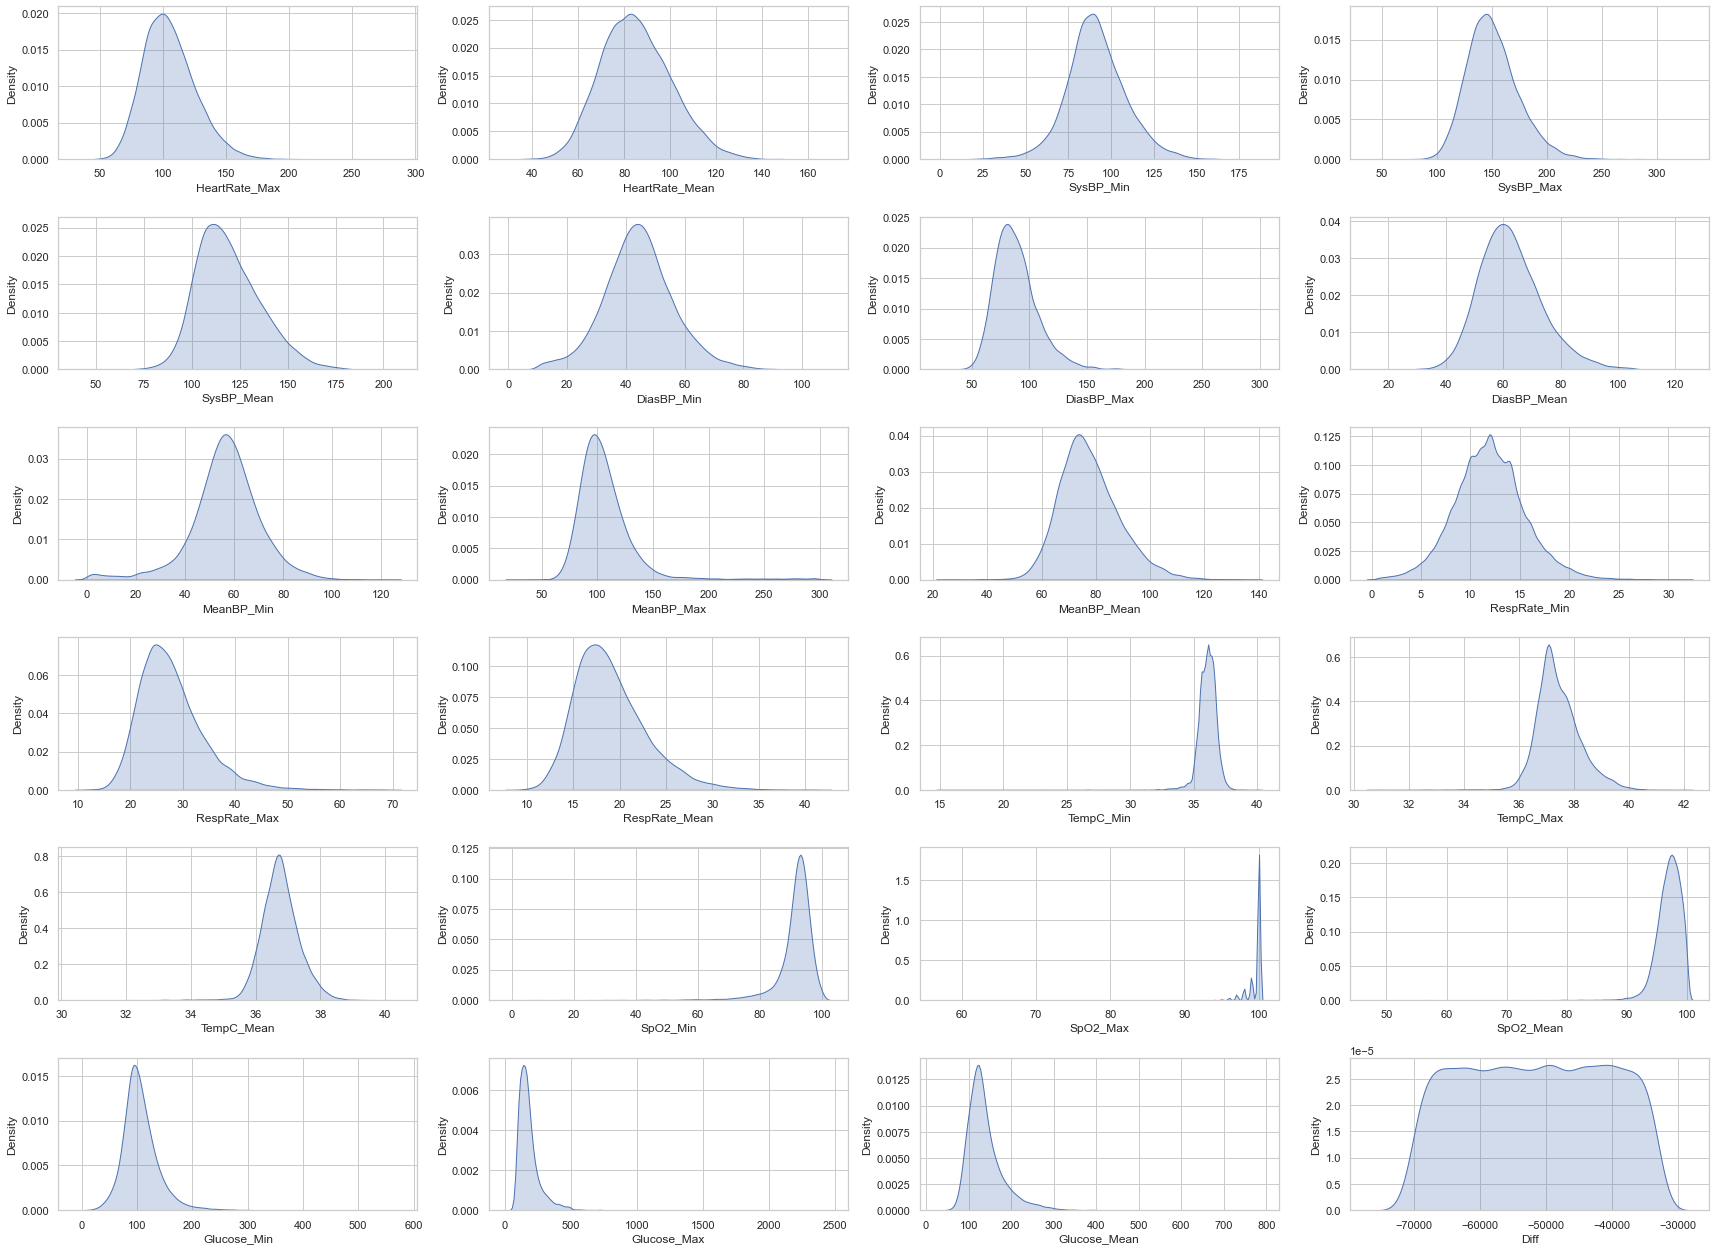

In [8]:
#Univariate kernel density distributions for numeric variables

sns.set(style="whitegrid")
plt.figure(figsize=(24, 20))

for n, col in enumerate(num_var):
  if n == 0:
    pass
  else:
    plt.subplot(7, 4, n)
    sns.kdeplot(x = col, 
                data = df_train, 
                fill=True)
plt.tight_layout()

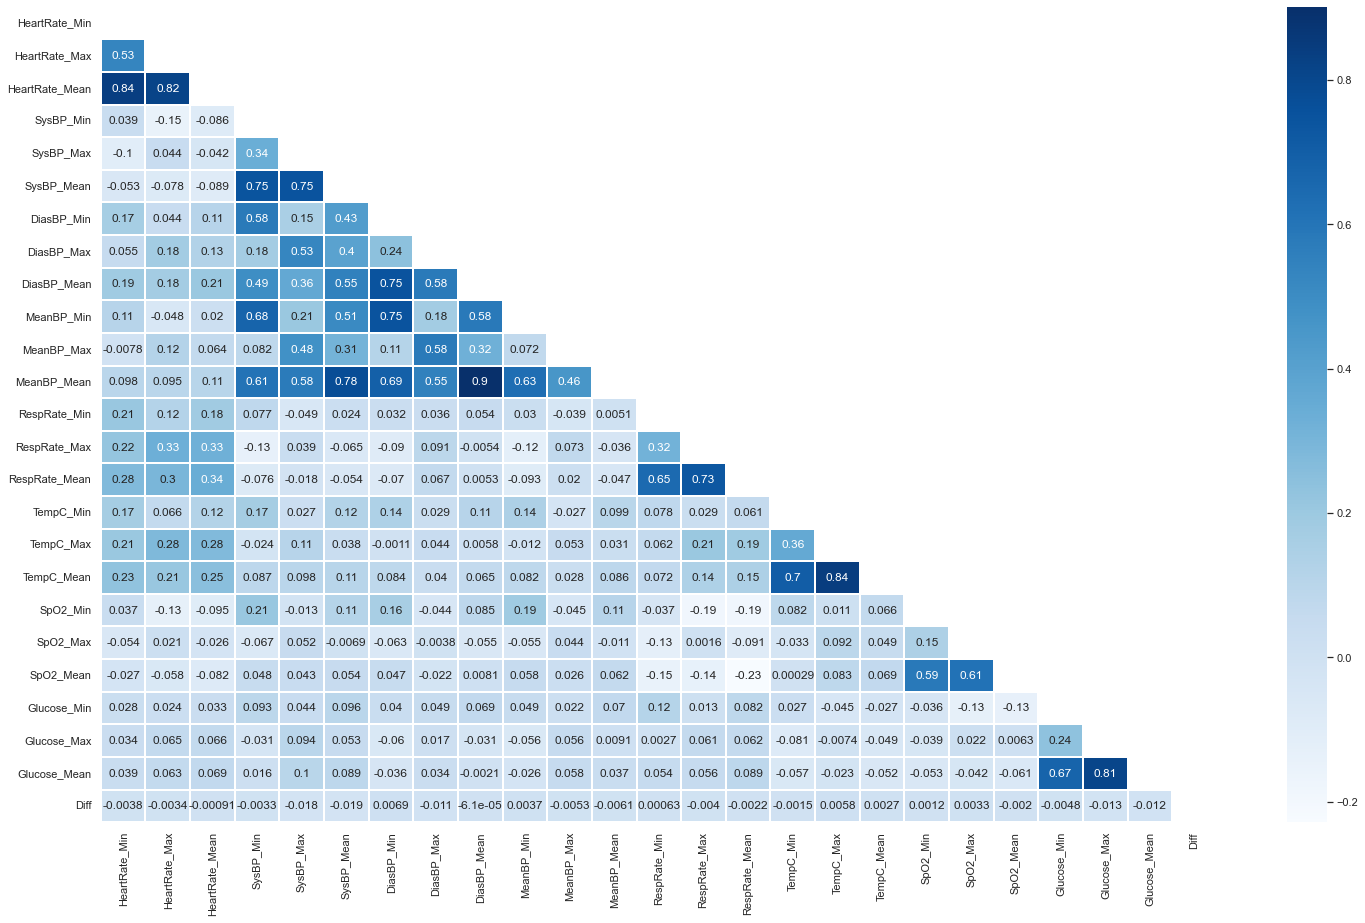

In [9]:
#Correlation matrix

df_corr = df_train[num_var].corr()

fig, ax = plt.subplots(figsize=(25,15))
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
ax = sns.heatmap(df_corr, mask = mask, annot = True, linewidths=0.1, linecolor='white', 
                 cmap=sns.color_palette("Blues", as_cmap=True))

Highly correlated variables: Glucose_Mean, TempC_Mean, MeanBP_Mean, HeartRate_Mean, Glucose_Max, TempC_Max, MeanBP_Mean, HeartRate_Min, HeartRate_Max

#### 2.2.2. Non numerical variables

In [10]:
#Levels for each non numerical variable - Train

for column in df_train[non_num_var]:
    print(f"{column} : {len(df_train[column].value_counts())}")

GENDER : 2
DOB : 14007
ADMITTIME : 19714
ADMISSION_TYPE : 3
INSURANCE : 5
RELIGION : 17
MARITAL_STATUS : 7
ETHNICITY : 41
DIAGNOSIS : 6193
ICD9_diagnosis : 1853
FIRST_CAREUNIT : 5


In [11]:
#Levels for each non numerical variable - Test

for column in df_test[non_num_var]:
    print(f"{column} : {len(df_test[column].value_counts())}")

GENDER : 2
DOB : 4599
ADMITTIME : 5156
ADMISSION_TYPE : 3
INSURANCE : 5
RELIGION : 16
MARITAL_STATUS : 7
ETHNICITY : 37
DIAGNOSIS : 2047
ICD9_diagnosis : 1024
FIRST_CAREUNIT : 5


Some non numerical variables have differentes levels between train and test sets, which could generate dimension problems when using dummies.

#### 2.3. Missing values

In [12]:
na_train = df_train.isnull().sum()
x_vals_train = na_train.index
y_vals_train = 100*na_train.values/len(df_train.index)

na_test = df_test.isnull().sum()
x_vals_test = na_test.index
y_vals_test = 100*na_test.values/len(df_test.index)

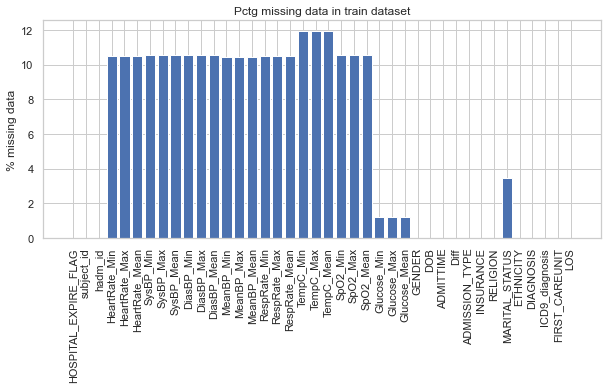

In [13]:
plt.figure(figsize=(10,4))
plt.xticks(rotation='vertical')
plt.bar(x_vals_train, y_vals_train)
plt.ylabel('% missing data')
plt.title('Pctg missing data in train dataset')
plt.show()

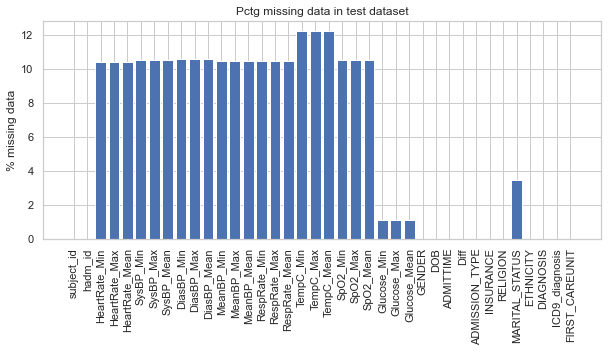

In [14]:
plt.figure(figsize=(10,4))
plt.xticks(rotation='vertical')
plt.bar(x_vals_test, y_vals_test)
plt.ylabel('% missing data')
plt.title('Pctg missing data in test dataset')
plt.show()

### 3. Data preprocessing

#### 3.1. Feature engineering

#### 3.1.1. Age

There are some variables that allow us to create an Age variable in both sets, that could be useful for prediction. Below we change the format of these variables to datetime and then use them to build 'Age', that is expressed in days and we change it to years.

In [15]:
#Creating age variable in train

df_train['Diff'] = df_train.apply(lambda x: timedelta(days=-x.Diff),axis=1)
df_train['DOB'] = df_train.apply(lambda x: dt.datetime.strptime(x.DOB,'%Y-%m-%d %H:%M:%S'),axis=1)
df_train['DOB'] = df_train.apply(lambda x: (x.DOB.to_pydatetime() - x.Diff),axis=1)
df_train['ADMITTIME'] = df_train.apply(lambda x: dt.datetime.strptime(x.ADMITTIME,'%Y-%m-%d %H:%M:%S'),axis=1)
df_train['ADMITTIME'] = df_train.apply(lambda x: (x.ADMITTIME.to_pydatetime() - x.Diff),axis=1)
df_train['Age'] = df_train.apply(lambda x: ((x.ADMITTIME.to_pydatetime() - x.DOB.to_pydatetime()).days),axis=1)
df_train['Age'] = df_train['Age'] / 365

In [16]:
#Creating age variable in test

df_test['Diff'] = df_test.apply(lambda x: timedelta(days=-x.Diff),axis=1)
df_test['DOB'] = df_test.apply(lambda x: dt.datetime.strptime(x.DOB,'%Y-%m-%d %H:%M:%S'),axis=1)
df_test['DOB'] = df_test.apply(lambda x: (x.DOB.to_pydatetime() - x.Diff),axis=1)
df_test['ADMITTIME'] = df_test.apply(lambda x: dt.datetime.strptime(x.ADMITTIME,'%Y-%m-%d %H:%M:%S'),axis=1)
df_test['ADMITTIME'] = df_test.apply(lambda x: (x.ADMITTIME.to_pydatetime() - x.Diff),axis=1)
df_test['Age']= df_test.apply(lambda x: ((x.ADMITTIME.to_pydatetime() - x.DOB.to_pydatetime()).days),axis=1)
df_test['Age'] = df_test['Age'] / 365

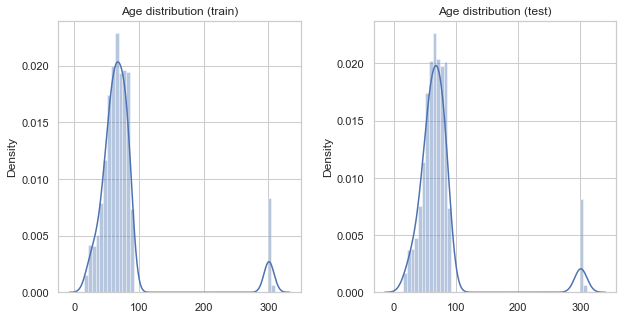

In [17]:
#Age distribution

fig, axes = plt.subplots(1, 2, figsize=(10,5))
fig.subplots_adjust(wspace=0.3)
sns.distplot(x=df_train["Age"], ax=axes[0])
axes[0].set_title("Age distribution (train)")
sns.distplot(x=df_test["Age"], ax=axes[1])
axes[1].set_title("Age distribution (test)")

plt.show()

Distribution plots show that there are some outliers observations above 100 years. According to the MIMIC III clinical database description:

"Dates of birth for patients aged over 89 were shifted to obscure their true age and comply with HIPAA regulations: these patients appear in the database with ages of over 300 years."

Therefore, we decided to replace all the observations above 89 years with NaN and then impute them. 

In [18]:
df_train.loc[df_train['Age'] > 89, 'Age'] = np.nan
df_test.loc[df_test['Age'] > 89, 'Age'] = np.nan

#### 3.1.2. Categorical variables

As seen in the EDA, many categorical variables have high cardinality. In this case, One-Hot encoding could lead to two problems, space consumption and high dimensionality. In order to avoid these problems, we decided to use Weight of Evidence (WOE) encoding, that measures the “strength” of a variable in relation to the target. With this encoding, the variables are transformed into continuous variables.

In [19]:
#Categorical features to encode

cat_col = ['INSURANCE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'DIAGNOSIS', 'FIRST_CAREUNIT','ICD9_diagnosis']

Variables GENDER and ADMISSION_TYPES are excluded because they are the ones with fewer categories and we decided to generate dummies for them.

In [20]:
woe = WOEEncoder()

# Fit
woe.fit(df_train[cat_col], df_train['HOSPITAL_EXPIRE_FLAG'])

# Transform
df_train[cat_col] = woe.transform(df_train[cat_col])
df_test[cat_col] = woe.transform(df_test[cat_col])

#### 3.1.3. Comorbidities

The diagnosis extra dataset has data about the different comorbidities of each patient. Since this information can be useful for prediction, we included a variable that represents the number of comorbidities of each patient.

In [21]:
#Creating variable for number of comorbidities

comorbidities = extra['HADM_ID'].value_counts()
df_train['comorbidities'] = df_train['hadm_id'].replace(to_replace=comorbidities.index,value=comorbidities.values)
df_test['comorbidities'] = df_test['hadm_id'].replace(to_replace=comorbidities.index,value=comorbidities.values)

#### 3.2. Cleaning features

In [22]:
#Checking common features

print("Features in train data but not in test:")
print(df_train.columns.difference(df_test.columns) )

print("\nFeatures in test data but not in train:")
print(df_test.columns.difference(df_train.columns) )

Features in train data but not in test:
Index(['HOSPITAL_EXPIRE_FLAG', 'LOS'], dtype='object')

Features in test data but not in train:
Index([], dtype='object')


In [23]:
#Removing features in train that are not in test

df_train = df_train.drop(['LOS'], axis = 1)

In [24]:
#Removing ID features that are not useful for prediction - Patient ID and Hospital Stay ID

df_train = df_train.drop(['subject_id', 'hadm_id'], axis = 1)
df_test = df_test.drop(['subject_id', 'hadm_id'], axis = 1)

In [25]:
#Removing ADMITTIME, DOB and Diff after creating variable Age

df_train = df_train.drop(['ADMITTIME', 'DOB','Diff'], axis = 1)
df_test = df_test.drop(['ADMITTIME', 'DOB', 'Diff'], axis = 1)

In [26]:
#Removing highly correlated variables

df_train = df_train.drop(['Glucose_Max', 'TempC_Max', 'MeanBP_Mean', 'HeartRate_Min', 'HeartRate_Max'], axis = 1)
df_test = df_test.drop(['Glucose_Max', 'TempC_Max', 'MeanBP_Mean', 'HeartRate_Min', 'HeartRate_Max'], axis = 1)

The elimination of highly correlated variables could be useful, in particular for KNN estimation, since these variables do not add new information to the model, but can affect the weight of distances.

#### 3.3. Imputing missing values

In [27]:
#Df copy

df_train_copy = df_train.copy()
df_test_copy = df_test.copy()

In [28]:
y_train = df_train_copy['HOSPITAL_EXPIRE_FLAG']
df_train_copy = df_train_copy.drop(['HOSPITAL_EXPIRE_FLAG'],axis = 1)

In [29]:
#Columns with missing values

na_cols_train = df_train_copy.columns[df_train_copy.isnull().any()].to_list()
na_cols_test = df_test_copy.columns[df_test_copy.isnull().any()].to_list()

In [30]:
#KNN imputer for missing values
knnimputer = KNNImputer() #By default 5 neighbors

#Fit
knnimputer.fit(df_train_copy[na_cols_train])

#Transform
df_train_copy[na_cols_train] = knnimputer.fit_transform(df_train_copy[na_cols_train])
df_test_copy[na_cols_test] = knnimputer.transform(df_test_copy[na_cols_test])

Missing values are imputed using KNNImputer, where each missing values are imputed using the mean value from n (5) nearest neighbors found in the training set. This imputer has been chosen because imputes an accurate estimate of the missing values without requiring as much information about the source of the missing values.

In turn, other imputers such as SimplerImputer (with mean and median) and IterativeImputer were tested, but using KNN a better performance was achieved.

#### 3.4. Getting dummies

In [31]:
#Creating df

dummies = ['GENDER', 'ADMISSION_TYPE']

df_train_ndumm = df_train_copy.drop(dummies, axis = 1)
df_test_ndumm = df_test_copy.drop(dummies, axis = 1)

df_train_dumm = df_train_copy[dummies]
df_test_dumm = df_test_copy[dummies]

In [32]:
#Getting dummies

df_train_dumm = pd.get_dummies(df_train_dumm, columns=dummies, drop_first = True)
df_test_dumm = pd.get_dummies(df_test_dumm, columns=dummies, drop_first = True)

In [33]:
#Concatenate df

X_train_scl = pd.concat([df_train_ndumm, df_train_dumm], axis = 1)
X_test_scl = pd.concat([df_test_ndumm, df_test_dumm], axis = 1)

In [34]:
#Comparing train and test columns

print("Features in train data but not in test:")
print(X_train_scl.columns.difference(X_test_scl.columns) )

print("\n Features in test data but not in train:")
print(X_test_scl.columns.difference(X_train_scl.columns) )

Features in train data but not in test:
Index([], dtype='object')

 Features in test data but not in train:
Index([], dtype='object')


#### 3.5. Standardization

In [35]:
#Standardization numerical features

# Instantiate scaler
scaler = preprocessing.StandardScaler()

# Fit to train 
scaler.fit(X_train_scl)

# Transform train and test
X_train = scaler.transform(X_train_scl)
X_test = scaler.transform(X_test_scl)

# Format data
X_train = pd.DataFrame(X_train, 
                            columns = X_train_scl.columns, 
                            index = X_train_scl.index)
X_test = pd.DataFrame(X_test, 
                           columns = X_test_scl.columns, 
                           index = X_test_scl.index)

In [36]:
print(X_train.shape)
print(X_test.shape)

(20885, 31)
(5221, 31)


### 4. Models

#### 4.1. Class imbalance

0    18540
1     2345
Name: HOSPITAL_EXPIRE_FLAG, dtype: int64


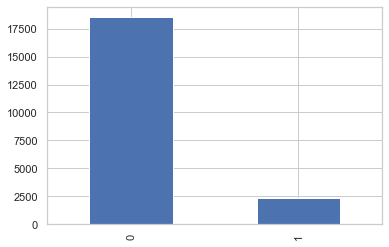

In [83]:
#Checking class imbalance

y_train.value_counts().plot(kind="bar")
print(y_train.value_counts()) 

As we can see, the majority class is the people who does not die, whereas the people who actually die are a minority. Therefore, the overall performance of the models trained on such data will be constrained by its ability to predict the minority class.  Hence, we will later deal with this and correct it.

#### 4.2. KNN

#### 4.2.1. Defining KNN model

**Algorithm**: the KNN classifier is runned with algorithm 'Brute'. KD Tree algorithm is discarded given the dimension of the data and Ball Tree because is highly dependant on some structure of the data that allows building the minimum hyperspheres. If data is noisy and number of dimensions is high, it is likely that we need higher number of balls, thus little gains from brute force. 

**Parameters**: the following parameters will be tuned using GridSearchCV to find the best ones:

- n_neighbors: number of neighbors to use. A list of numbers between 70 and 500 is provided.
- weights: weight function used in prediction. The two valid options are provided. 
- metric: metric used for distance computation. A list of valid metrics for brute algorithm is provided.
- p: power parameter for the Minkowski metric.  

Then, probabilities are calibrated to adjust for class-imbalance.

In [63]:
%%time

#Intantiate the model

MyKNN = KNeighborsClassifier(algorithm='brute')

#Grid of values

k_vals = [70, 100, 200, 300] 
weights = ['uniform', 'distance']
k_p = [1,2,3]
metrics = sorted(sklearn.neighbors.VALID_METRICS_SPARSE['brute'])
metrics.remove('precomputed')

grid_values = {'n_neighbors':k_vals, 'weights':weights, 'metric':metrics, 'p':k_p}

grid_knn_acc = GridSearchCV(MyKNN, param_grid = grid_values, scoring = 'roc_auc', cv=10, n_jobs=-1, verbose=3)

#Fit values

grid_knn_acc.fit(X_train, y_train)

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
CPU times: total: 9.17 s
Wall time: 20min 9s


GridSearchCV(cv=10, estimator=KNeighborsClassifier(algorithm='brute'),
             n_jobs=-1,
             param_grid={'metric': ['cityblock', 'cosine', 'euclidean', 'l1',
                                    'l2', 'manhattan'],
                         'n_neighbors': [70, 100, 200, 300], 'p': [1, 2, 3],
                         'weights': ['uniform', 'distance']},
             scoring='roc_auc', verbose=3)

best parameters: {'metric': 'cityblock', 'n_neighbors': 200, 'p': 1, 'weights': 'distance'}
best score:      0.87418 (+/-0.01460)


,param_metric,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
17,cityblock,200,3,distance,"{'metric': 'cityblock', 'n_neighbors': 200, 'p...",0.858691,0.885266,0.875545,0.850511,0.874601,0.870377,0.897189,0.880595,0.856895,0.892125,0.874180,0.014598,1
137,manhattan,200,3,distance,"{'metric': 'manhattan', 'n_neighbors': 200, 'p...",0.858691,0.885266,0.875545,0.850511,0.874601,0.870377,0.897189,0.880595,0.856895,0.892125,0.874180,0.014598,1
135,manhattan,200,2,distance,"{'metric': 'manhattan', 'n_neighbors': 200, 'p...",0.858691,0.885266,0.875545,0.850511,0.874601,0.870377,0.897189,0.880595,0.856895,0.892125,0.874180,0.014598,1
133,manhattan,200,1,distance,"{'metric': 'manhattan', 'n_neighbors': 200, 'p...",0.858691,0.885266,0.875545,0.850511,0.874601,0.870377,0.897189,0.880595,0.856895,0.892125,0.874180,0.014598,1
85,l1,200,1,distance,"{'metric': 'l1', 'n_neighbors': 200, 'p': 1, '...",0.858691,0.885266,0.875545,0.850511,0.874601,0.870377,0.897189,0.880595,0.856895,0.892125,0.874180,0.014598,1
15,cityblock,200,2,distance,"{'metric': 'cityblock', 'n_neighbors': 200, 'p...",0.858691,0.885266,0.875545,0.850511,0.874601,0.870377,0.897189,0.880595,0.856895,0.892125,0.874180,0.014598,1
87,l1,200,2,distance,"{'metric': 'l1', 'n_neighbors': 200, 'p': 2, '...",0.858691,0.885266,0.875545,0.850511,0.874601,0.870377,0.897189,0.880595,0.856895,0.892125,0.874180,0.014598,1
13,cityblock,200,1,distance,"{'metric': 'cityblock', 'n_neighbors': 200, 'p...",0.858691,0.885266,0.875545,0.850511,0.874601,0.870377,0.897189,0.880595,0.856895,0.892125,0.874180,0.014598,1
89,l1,200,3,distance,"{'metric': 'l1', 'n_neighbors': 200, 'p': 3, '...",0.858691,0.885266,0.875545,0.850511,0.874601,0.870377,0.897189,0.880595,0.856895,0.892125,0.874180,0.014598,1
21,cityblock,300,2,distance,"{'metric': 'cityblock', 'n_neighbors': 300, 'p...",0.857253,0.881172,0.872568,0.850513,0.876247,0.871949,0.896320,0.877689,0.855893,0.895147,0.873475,0.014761,10


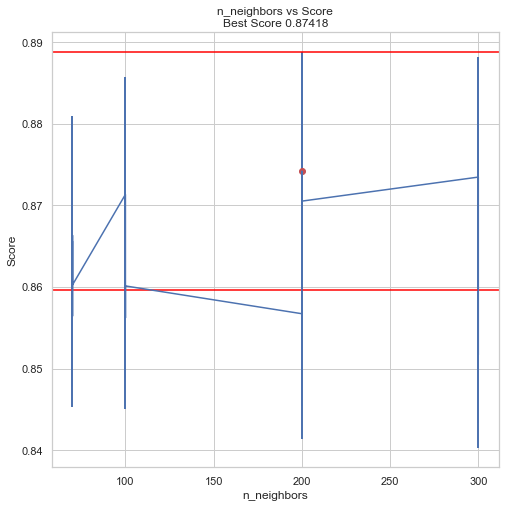

In [64]:
#Best parameters

GridSearch_table_plot(grid_knn_acc, "n_neighbors", negative=False, display_all_params=False)

In [65]:
#Prediction

#In sample
p_pred = grid_knn_acc.predict_proba(X_train)[:,1]

#Test
p_pred_KNN = grid_knn_acc.predict_proba(X_test)[:,1]

#### 4.2.2. Class imbalance - Calibrating Probabilities

We use CalibratedClassifierCV to calibrate the probabilities of KNN model and deal with class imbalance. 

In [66]:
%%time

#Intantiate the model

cal = CalibratedClassifierCV(grid_knn_acc, cv=5, method='isotonic', n_jobs=-1)

#Fit

cal.fit(X_train, y_train)

#Predict

p_pred_test_cal = cal.predict_proba(X_test)[:, 1]

CPU times: total: 18.7 s
Wall time: 53min 21s


#### 4.2.3. Kaggle submission

In [69]:
# Produce .csv for kaggle testing 
KNN_test_predictions_submit = pd.DataFrame({"icustay_id": X_test.index, "HOSPITAL_EXPIRE_FLAG": p_pred_test_cal})
KNN_test_predictions_submit.to_csv("KNN_test_predictions_submit1.csv", index = False)

For the final kaggle submission we use the calibrated model, which is the one that has the best performance.

#### 4.3. SVM

#### 4.3.1. Defining SVM model

We start difining MySVC, where we specify 'probability=True' since we want to predict probabilities. Then we defined the grid of values for the parameters that we want to tune using GridSearchCV to find the best ones:

- C: regularization parameter. A list of values between 0.1 and 10 is provided.
- gamma: kernel coefficient. A list of values between 0.01 and 0.75 is provided.
- kernel: we are not able to add more options for the kernel type due to computational time. Hence, we use 'rbf' that is the kernel by default. But we would like to test also the option 'linear'.

Then, we use re-sampling and re-weighting techniques to adjust for class-imbalance.

In [37]:
%%time

#Intantiate the model

MySVC = SVC(probability=True)

#Grid of values

grid_svc_values = {'C':[0.1, 1, 10], 'gamma':[0.01,0.25,0.50,0.75]} #,'kernel':['linear', 'rbf']}

grid_svc_acc = GridSearchCV(MySVC, param_grid = grid_svc_values,scoring = 'roc_auc', cv=5, n_jobs=-1)

#Fit

grid_svc_acc.fit(X_train, y_train)

CPU times: total: 2min
Wall time: 2h 7min 44s


GridSearchCV(cv=5, estimator=SVC(probability=True), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.01, 0.25, 0.5, 0.75]},
             scoring='roc_auc')

best parameters: {'C': 1, 'gamma': 0.01}
best score:      0.88318 (+/-0.00582)


,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,1,0.01,"{'C': 1, 'gamma': 0.01}",0.877806,0.881491,0.876548,0.889970,0.890077,0.883179,0.005820,1
0,0.1,0.01,"{'C': 0.1, 'gamma': 0.01}",0.876008,0.873356,0.873430,0.886204,0.886748,0.879149,0.006060,2
8,10,0.01,"{'C': 10, 'gamma': 0.01}",0.871850,0.878169,0.868175,0.877239,0.883191,0.875725,0.005216,3
5,1,0.25,"{'C': 1, 'gamma': 0.25}",0.828597,0.821335,0.832673,0.837875,0.833508,0.830797,0.005574,4
1,0.1,0.25,"{'C': 0.1, 'gamma': 0.25}",0.828586,0.821316,0.832607,0.837862,0.833507,0.830776,0.005573,5
9,10,0.25,"{'C': 10, 'gamma': 0.25}",0.825965,0.819903,0.831446,0.831073,0.827234,0.827124,0.004190,6
2,0.1,0.5,"{'C': 0.1, 'gamma': 0.5}",0.793788,0.787184,0.798720,0.805006,0.799885,0.796917,0.006033,7
6,1,0.5,"{'C': 1, 'gamma': 0.5}",0.793933,0.786978,0.798808,0.805024,0.799751,0.796899,0.006083,8
10,10,0.5,"{'C': 10, 'gamma': 0.5}",0.793109,0.786672,0.799833,0.803959,0.799669,0.796648,0.006079,9
7,1,0.75,"{'C': 1, 'gamma': 0.75}",0.773137,0.764630,0.772393,0.781971,0.776023,0.773631,0.005623,10


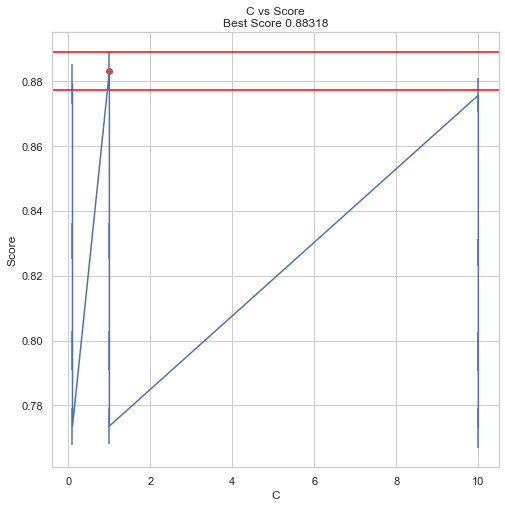

In [38]:
GridSearch_table_plot(grid_svc_acc, "C", negative=False, display_all_params=False)

In [39]:
#Prediction

#In sample
p_pred_svc = grid_svc_acc.predict_proba(X_train)[:,1]

#Test
p_pred_test_svc = grid_svc_acc.predict_proba(X_test)[:,1]

#### 4.3.2. Class imbalance

#### 4.3.2.1. Re-sampling: Under-sampling

One approach to class imbalance is under-representing (underweighting) the popular class. For this, we use RandomUnderSampler, which under-sample the majority class by randomly picking samples without replacement.

After under-sampling, we run again the GridSearchCV using the resampled X_train and Y_train. Then we fit the model, predict and reweight the probabilities. 

(4690, 31)


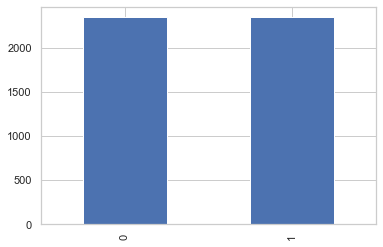

In [52]:
#Under sampling

under = RandomUnderSampler()

X_train_u, y_train_u = under.fit_resample(X_train, y_train)

y_train_u.value_counts().plot(kind="bar")
print(X_train_u.shape)

In [79]:
MySVC_under = SVC(probability=True)

grid_svc_acc_under = GridSearchCV(MySVC_under, param_grid = grid_svc_values,scoring = 'roc_auc', cv=5, n_jobs=-1)

grid_svc_acc_under.fit(X_train_u,y_train_u)

def reweight(pi,q1,r1):
    r0 = 1-r1
    q0 = 1-q1
    tot = pi*(q1/r1)+(1-pi)*(q0/r0)
    w = pi*(q1/r1)
    w /= tot
    return w

q1_under = y_train.sum()/len(y_train)
r1_under = y_train_u.sum()/len(y_train_u)

p_pred_under = grid_svc_acc_under.predict_proba(X_test)
p_pred_under_re = pd.Series(p_pred_under[:,1]).apply(reweight,args=(q1_under,r1_under))

best parameters: {'C': 1, 'gamma': 0.01}
best score:      0.88670 (+/-0.00613)


,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,1,0.01,"{'C': 1, 'gamma': 0.01}",0.880297,0.891735,0.879610,0.895136,0.886739,0.886704,0.006128,1
8,10,0.01,"{'C': 10, 'gamma': 0.01}",0.868377,0.883025,0.873468,0.891035,0.885248,0.880231,0.008197,2
0,0.1,0.01,"{'C': 0.1, 'gamma': 0.01}",0.875446,0.880670,0.871191,0.881056,0.877301,0.877133,0.003635,3
9,10,0.25,"{'C': 10, 'gamma': 0.25}",0.803738,0.809766,0.814253,0.817374,0.823028,0.813632,0.006565,4
5,1,0.25,"{'C': 1, 'gamma': 0.25}",0.806484,0.810230,0.810530,0.819979,0.820914,0.813627,0.005755,5
1,0.1,0.25,"{'C': 0.1, 'gamma': 0.25}",0.799142,0.795691,0.796041,0.804768,0.808375,0.800803,0.004992,6
2,0.1,0.5,"{'C': 0.1, 'gamma': 0.5}",0.745687,0.775547,0.767445,0.776076,0.774305,0.767812,0.011489,7
6,1,0.5,"{'C': 1, 'gamma': 0.5}",0.745896,0.770382,0.765493,0.777283,0.777292,0.767269,0.011579,8
10,10,0.5,"{'C': 10, 'gamma': 0.5}",0.743295,0.771264,0.763615,0.777256,0.777883,0.766663,0.012764,9
3,0.1,0.75,"{'C': 0.1, 'gamma': 0.75}",0.710105,0.745378,0.742854,0.749624,0.754395,0.740471,0.015681,10


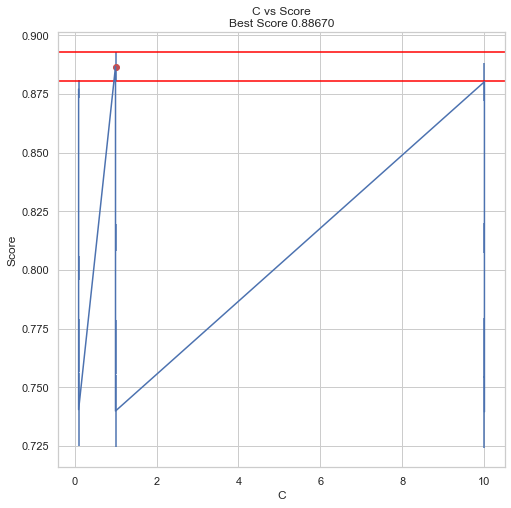

In [81]:
GridSearch_table_plot(grid_svc_acc_under, "C", negative=False, display_all_params=False)

#### 4.3.2.2. Re-sampling: class_weight=balanced

Another approach to class imbalance is using SVC with the class_weight="balanced" argument, which corresponds to oversampling.
In this case, the algorithm will automatically adjust the weights inversely proportional to the class frequencies. After fitting and predicting, the probabilities are reweighted. 

In [77]:
#Class_weight

%%time

MySVC_balanced = SVC(class_weight='balanced', probability=True)

grid_svc_acc_balanced = GridSearchCV(MySVC_balanced, param_grid = grid_svc_values,scoring = 'roc_auc', cv=5, n_jobs=-1)

grid_svc_acc_balanced.fit(X_train,y_train)

def reweight(pi,q1,r1):
    r0 = 1-r1
    q0 = 1-q1
    tot = pi*(q1/r1)+(1-pi)*(q0/r0)
    w = pi*(q1/r1)
    w /= tot
    return w

q1 = y_train.sum()/len(y_train)
r1 = 0.5

p_pred_sam = grid_svc_acc_balanced.predict_proba(X_test)
p_pred_sam_re = pd.Series(p_pred_sam[:,1]).apply(reweight,args=(q1,r1))

CPU times: total: 1min 23s
Wall time: 1h 13min 35s


best parameters: {'C': 1, 'gamma': 0.01}
best score:      0.89619 (+/-0.00593)


,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,1,0.01,"{'C': 1, 'gamma': 0.01}",0.892404,0.890581,0.892712,0.906803,0.898427,0.896185,0.005925,1
0,0.1,0.01,"{'C': 0.1, 'gamma': 0.01}",0.887762,0.886362,0.886593,0.902401,0.894635,0.891551,0.006215,2
8,10,0.01,"{'C': 10, 'gamma': 0.01}",0.880753,0.882443,0.880821,0.890740,0.884543,0.883860,0.003707,3
5,1,0.25,"{'C': 1, 'gamma': 0.25}",0.827342,0.821901,0.834073,0.837522,0.830087,0.830185,0.005397,4
9,10,0.25,"{'C': 10, 'gamma': 0.25}",0.825965,0.819903,0.831446,0.831073,0.827234,0.827124,0.004190,5
1,0.1,0.25,"{'C': 0.1, 'gamma': 0.25}",0.822466,0.813245,0.819709,0.828519,0.828395,0.822467,0.005734,6
2,0.1,0.5,"{'C': 0.1, 'gamma': 0.5}",0.797119,0.786365,0.800158,0.807094,0.801259,0.798399,0.006831,7
6,1,0.5,"{'C': 1, 'gamma': 0.5}",0.792953,0.786153,0.800927,0.804085,0.799957,0.796815,0.006453,8
10,10,0.5,"{'C': 10, 'gamma': 0.5}",0.793109,0.786672,0.799833,0.803959,0.799669,0.796648,0.006079,9
3,0.1,0.75,"{'C': 0.1, 'gamma': 0.75}",0.772737,0.764056,0.773409,0.783073,0.778603,0.774376,0.006382,10


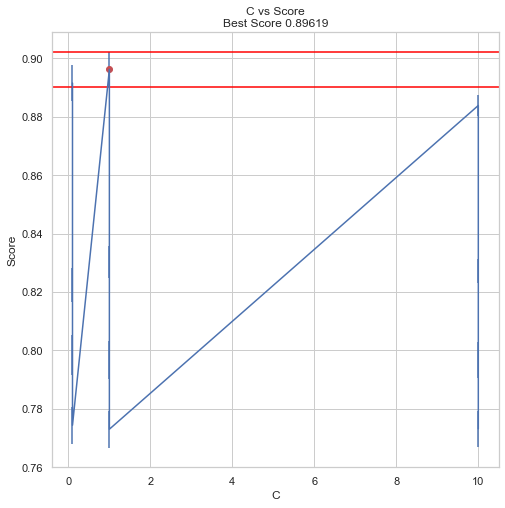

In [82]:
GridSearch_table_plot(grid_svc_acc_balanced, "C", negative=False, display_all_params=False)

#### 4.3.3. Kaggle submission

In [74]:
# Produce .csv for kaggle testing 
SMV_test_predictions_submit = pd.DataFrame({"icustay_id": X_test.index, "HOSPITAL_EXPIRE_FLAG": p_pred_under_re})
SMV_test_predictions_submit.to_csv("SMV_test_predictions_submit.csv", index = False)

For the final kaggle submission we use the SVM model that was trained with the under-sampling, which is the one that has the best performance.